# Import Libraries

In [79]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense , Flatten , Dropout , Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [63]:
def df(path):
    class_paths = []
    classes = []
    for label in os.listdir(path):
        for file in os.listdir(path+label):
            class_paths.append(path+label+"/"+file)
            classes.append(label)
    data = pd.DataFrame({"class path":class_paths , "class":classes})
    return pd.DataFrame({"class path":class_paths , "class":classes})

In [ ]:
train_df = df("Datasets/MRI/brain-tumor-mri-dataset/Training/")

In [65]:
train_df.head(5)

,class path,class
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary


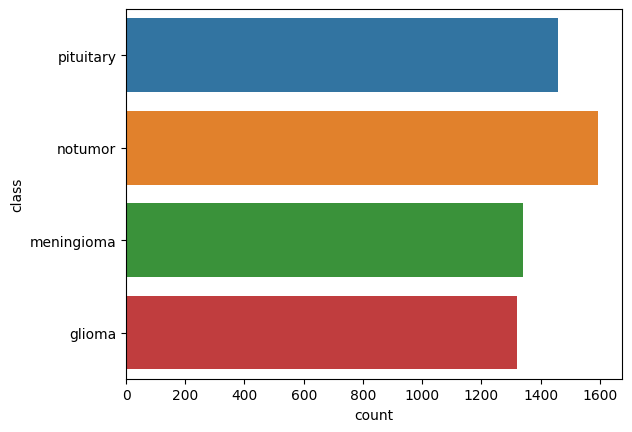

In [66]:
# plt.style.use('dark_background')
# plt.style.use('seaborn-v0_8-dark-palette')
sns.countplot(data = train_df , y = train_df['class'])
plt.show()

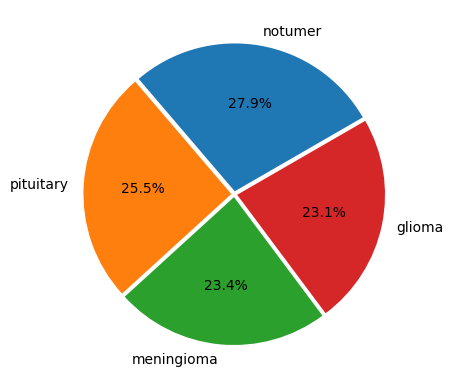

In [67]:
plt.pie(train_df['class'].value_counts(),labels=['notumer','pituitary','meningioma','glioma'], autopct = '%1.1f%%',explode = [0.02,0.02,0.02,0.02],startangle = 30)
plt.show()

In [ ]:
test_df = df("Datasets/MRI/brain-tumor-mri-dataset/Testing/")

In [69]:
test_df.head(5)

,class path,class
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary


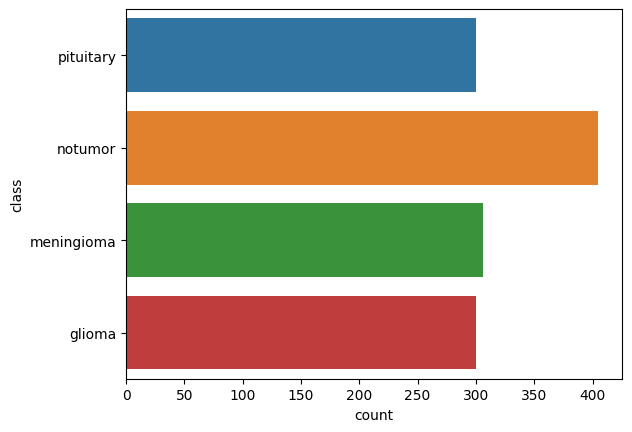

In [70]:
sns.countplot(data = test_df , y = test_df['class'])
plt.show()

In [71]:
test_df["class"].value_counts()

class
notumor       405
meningioma    306
pituitary     300
glioma        300
Name: count, dtype: int64

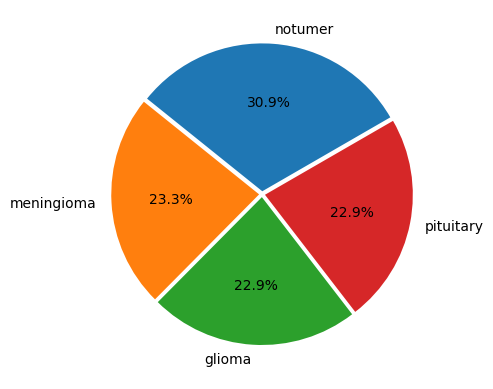

In [72]:
plt.pie(test_df['class'].value_counts(),labels=['notumer','meningioma','glioma','pituitary'], autopct = '%1.1f%%',explode = [0.02,0.02,0.02,0.02],startangle = 30)
plt.show()

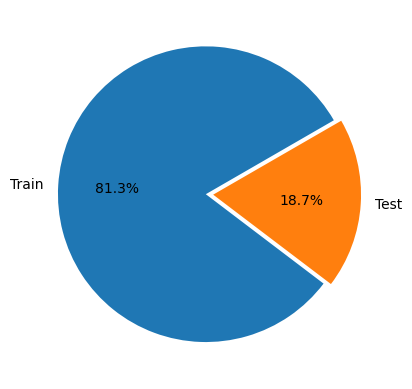

In [73]:
plt.pie(x = [len(train_df),len(test_df)] , labels = ['Train','Test'] , autopct = "%1.1f%%" , explode = [0,0.05],startangle = 30)
plt.show()

In [74]:
valid_df , test_df = train_test_split(test_df , test_size = 0.5 , random_state = 20 , stratify = test_df['class'])

In [75]:
valid_df.head(5)

,class path,class
1297,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
723,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
61,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
778,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
1120,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


In [76]:
batch_size = 32
image_size = (299,299)

gen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    brightness_range = (0.9,1.1)
)

ts_gen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_gen = gen.flow_from_dataframe(
    train_df,
    x_col = 'class path',
    y_col = 'class',
    target_size = image_size,
    batch_size = batch_size
)
valid_gen = ts_gen.flow_from_dataframe(
    valid_df ,
    x_col = 'class path',
    y_col = 'class',
    target_size =image_size,
    batch_size = batch_size
)
test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col = 'class path',
    y_col = 'class',
    target_size = image_size,
    batch_size = batch_size,
    shuffle = False
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


batch image shape : (32, 299, 299, 3)
batch label shape : (32, 4)


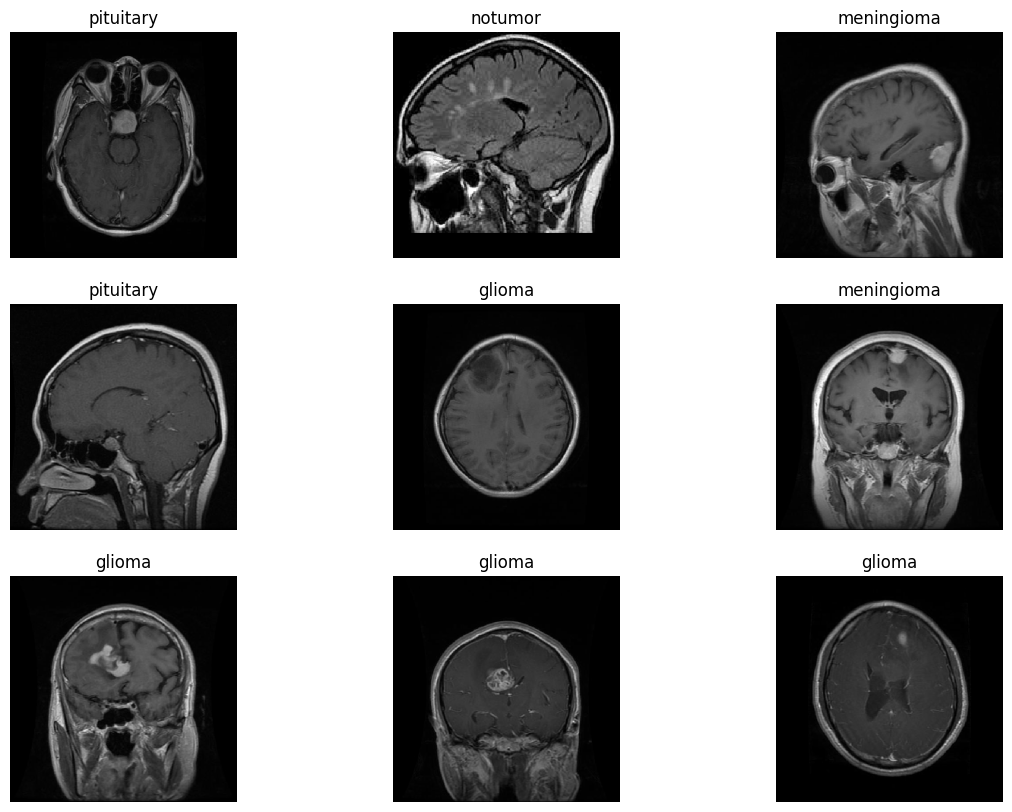

In [77]:
image , label = next(train_gen)
classes = list(train_gen.class_indices.keys())
print("batch image shape :",image.shape)
print("batch label shape :",label.shape)
plt.figure(figsize=(14,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow((image[i]+1)/2)
    plt.axis('off')
    class_name = classes[np.argmax(label[i])]
    plt.title(class_name)
plt.show()

# Building Model

In [80]:
image_shape = (299,299,3)

inputs = Input(shape = image_shape)

base_model = Xception(include_top = False , weights = "imagenet" , input_tensor = inputs , pooling = 'max')

x = base_model.output
x = Dropout(rate = 0.3)(x)
x = Dense(128,activation = 'relu')(x)
x = Dropout(rate = 0.3)(x)
outputs = Dense(4,activation = 'softmax')(x)

model = Model(inputs = inputs , outputs = outputs)

model.compile(optimizer = Adam(learning_rate = 0.001) ,loss = 'categorical_crossentropy' , metrics = ['accuracy','precision','recall'])
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_4[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add_24[0][0]    

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [84]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced',
                                     classes=np.unique(train_gen.classes),
                                     y=train_gen.classes)
class_weight_dict = {i:w for i,w in enumerate(class_weights)}

for i, name in enumerate(classes):
    if name != 'notumor':
        class_weight_dict[i] *= 1.3

In [85]:
new_weights = dict(zip(classes , class_weight_dict.values()))
new_weights

{'glioma': 1.405299015897048,
 'meningioma': 1.3864077669902912,
 'notumor': 0.8952978056426333,
 'pituitary': 1.2741249142072752}

In [88]:
hist = model.fit(
    train_gen,
    validation_data = valid_gen,
    class_weight = class_weight_dict,
    epochs = 10,
    shuffle = False
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 455ms/step - accuracy: 0.9849 - loss: 0.0633 - precision: 0.9868 - recall: 0.9840 - val_accuracy: 0.9176 - val_loss: 0.4095 - val_precision: 0.9232 - val_recall: 0.9176
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 456ms/step - accuracy: 0.9883 - loss: 0.0531 - precision: 0.9888 - recall: 0.9870 - val_accuracy: 0.8336 - val_loss: 0.9550 - val_precision: 0.8374 - val_recall: 0.8336
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 452ms/step - accuracy: 0.9956 - loss: 0.0260 - precision: 0.9959 - recall: 0.9955 - val_accuracy: 0.9771 - val_loss: 0.0940 - val_precision: 0.9786 - val_recall: 0.9771
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 454ms/step - accuracy: 0.9898 - loss: 0.0488 - precision: 0.9906 - recall: 0.9886 - val_accuracy: 0.8137 - val_loss: 0.7617 - val_precision: 0.8214 - val_recall: 0.8076
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 455ms/step - accuracy: 0.9864 - loss: 0.0539 - precision: 0.9878 - recall: 0.9850 - val_accuracy: 0.9557

In [89]:
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 218ms/step - accuracy: 0.9878 - loss: 0.0542 - precision: 0.9890 - recall: 0.9873
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9572 - loss: 0.2231 - precision: 0.9585 - recall: 0.9572
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.9545 - loss: 0.3464 - precision: 0.9558 - recall: 0.9506
Train Loss: 0.0538
Train Accuracy: 98.79%
--------------------
Validation Loss: 0.1760
Validation Accuracy: 95.73%
--------------------
Test Loss: 0.2620
Test Accuracy: 96.19%


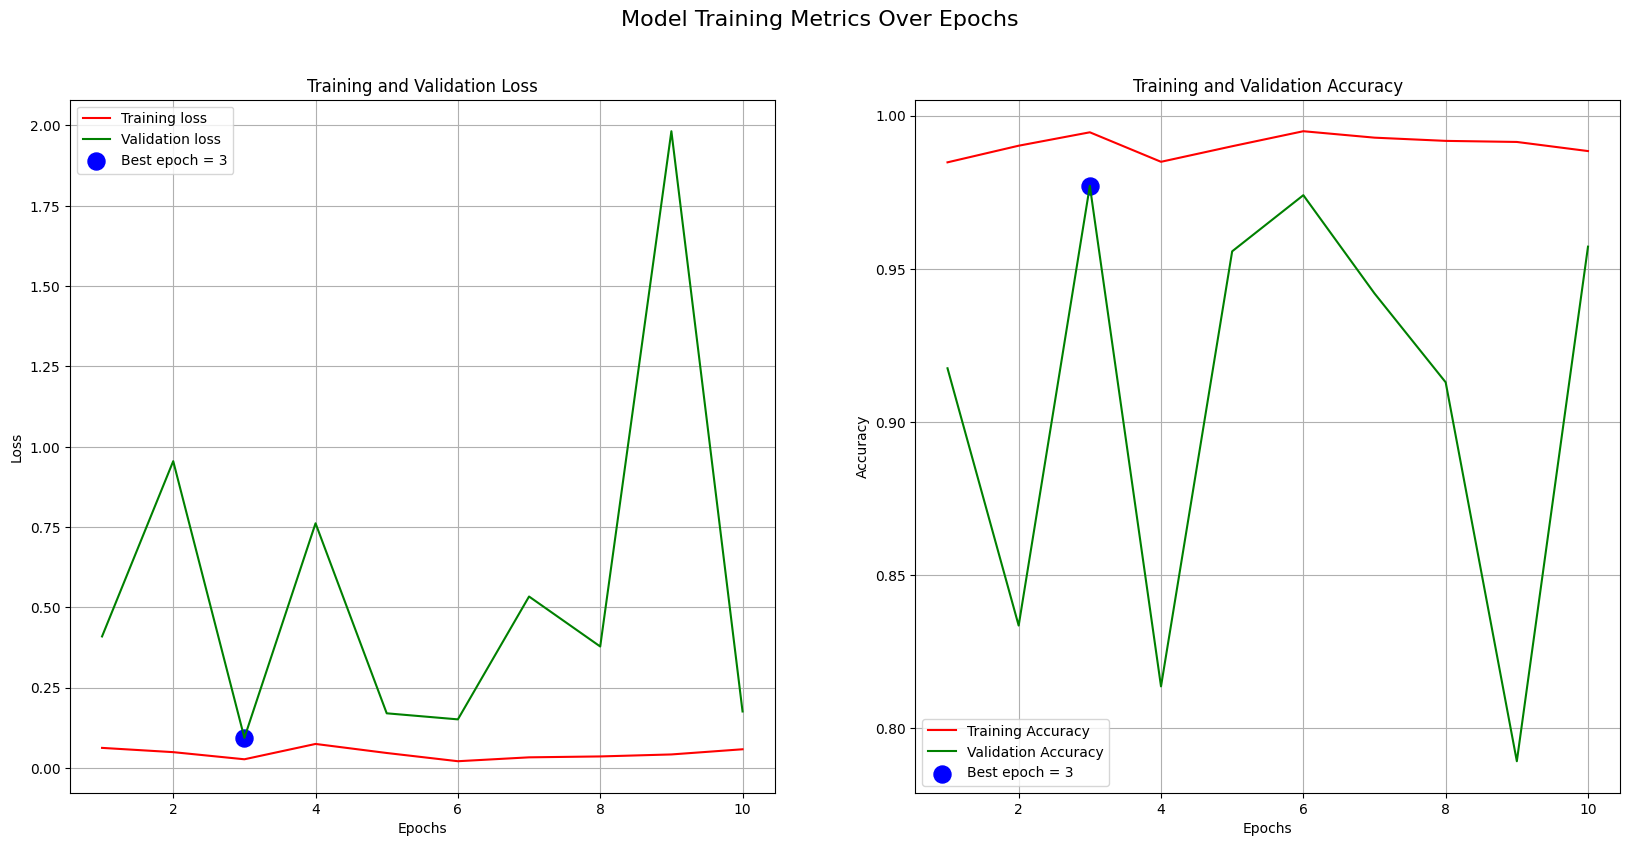

In [90]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]


Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

plt.figure(figsize=(20, 9))


plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 389ms/step


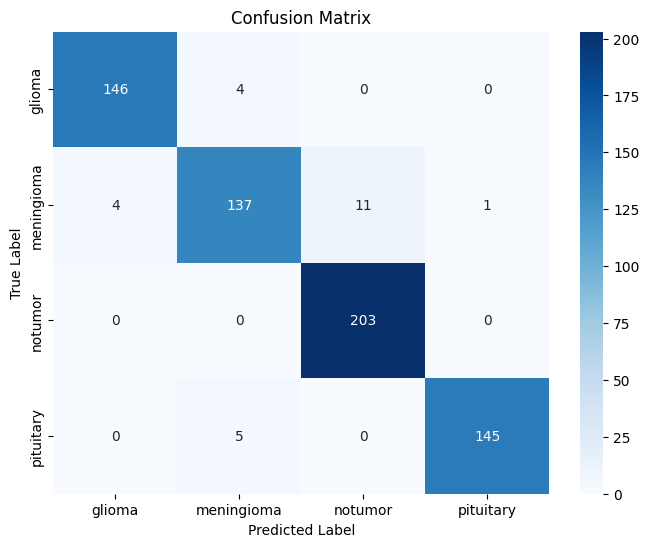

              precision    recall  f1-score   support

      glioma       0.97      0.97      0.97       150
  meningioma       0.94      0.90      0.92       153
     notumor       0.95      1.00      0.97       203
   pituitary       0.99      0.97      0.98       150

    accuracy                           0.96       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.96      0.96      0.96       656



In [91]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get class names
class_names = list(test_gen.class_indices.keys())

# Predict on test set
y_pred_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_gen.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
model.save("model/Model(new).keras")

In [ ]:
plt.figure(figsize=(12, 12))
img = Image.open("/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0000.jpg")
resized_img = img.resize((299,299))
img = np.asarray(resized_img)
img = np.expand_dims(img , axis = 0)
img = preprocess_input(img)
pred = model.predict(img)
probs = list(pred[0])
labels = classes
plt.subplot(2, 1, 1)
plt.imshow(resized_img)
plt.subplot(2, 1, 2)
bars = plt.barh(labels, probs)
plt.xlabel('Probability', fontsize=15)
ax = plt.gca()
ax.bar_label(bars, fmt = '%.2f')
plt.show()